<a href="https://colab.research.google.com/github/1moi6/pyfuzzy-toolbox/blob/main/notebooks_colab/04_dynamics/02_pfuzzy_continuous_predator_prey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema p-Fuzzy Contínuo: Predador-Presa

## 📘 Introdução

Este notebook implementa um **sistema dinâmico p-fuzzy contínuo** para modelar a interação entre **presas e predadores**, baseado no exemplo do livro:

> Barros, L. C., Bassanezi, R. C., & Lodwick, W. A. (2017).  
> *A First Course in Fuzzy Logic, Fuzzy Dynamical Systems, and Biomathematics*

---

## 🎯 O que é um Sistema p-Fuzzy Contínuo?

Um **sistema p-fuzzy contínuo** modela a evolução temporal usando **equações diferenciais ordinárias (EDOs)** onde a função de evolução é determinada por **regras fuzzy**.

### Sistema Contínuo:
$$\frac{dx}{dt} = f(x)$$

Onde $f(x)$ é definido por um **Sistema de Inferência Fuzzy (FIS)**.

---

## 🦊 Modelo Lotka-Volterra Fuzzy

O modelo clássico de Lotka-Volterra descreve:

$$\frac{dx_1}{dt} = \alpha x_1 - \beta x_1 x_2 \quad \text{(presas)}$$

$$\frac{dx_2}{dt} = \delta x_1 x_2 - \gamma x_2 \quad \text{(predadores)}$$

### Versão Fuzzy:
As taxas de mudança são determinadas por regras fuzzy ao invés de parâmetros fixos $\alpha, \beta, \gamma, \delta$.

**Vantagens:**
- ✅ Incorpora conhecimento especialista
- ✅ Não requer calibração paramétrica precisa
- ✅ Captura comportamentos não-lineares complexos

---

## 🚀 Vamos começar!

## Instalação e Imports

In [ ]:
# Instalar pyfuzzy-toolbox
!pip install pyfuzzy-toolbox matplotlib numpy -q

In [1]:
import fuzzy_systems as fs
import numpy as np
import matplotlib.pyplot as plt

print("✅ Bibliotecas importadas com sucesso!")

✅ MamdaniLearning implementado com sucesso!

Características:
  • Aprendizado por gradiente: batch, online, mini-batch
  • Otimização metaheurística: PSO, DE, GA
  • Defuzzificação: COG e COS
  • Caching de ativações para otimização eficiente
  • Extração de regras linguísticas
✅ Módulo de EDO Fuzzy implementado com sucesso!

Características:
  • Integração completa com fuzzy_systems.core
  • Suporte a FuzzySet, triangular, gaussiana, trapezoidal
  • Método de α-níveis vetorizado
  • Paralelização automática (joblib)
  • Condições iniciais e parâmetros fuzzy
  • Visualização de envelopes por α-nível
✅ Bibliotecas importadas com sucesso!


---

## 1️⃣ Criar o Sistema de Inferência Fuzzy

Vamos criar um FIS que implementa as regras fuzzy para o modelo contínuo.

In [2]:
# Criar sistema Mamdani para predador-presa contínuo
fis = fs.MamdaniSystem(name="Lotka-Volterra Fuzzy Contínuo")

# ========================================
# ENTRADAS: Presas (x₁) e Predadores (x₂)
# ========================================

fis.add_input('prey', (0, 100))
fis.add_input('predator', (0, 100))

# Termos linguísticos (3 níveis para simplicidade)
for var in ['prey', 'predator']:
    fis.add_term(var, 'baixa', 'gaussian', (15, 10))
    fis.add_term(var, 'media', 'gaussian', (50, 15))
    fis.add_term(var, 'alta', 'gaussian', (85, 10))

print("✅ Variáveis de entrada criadas:")
print(f"   • prey: 3 termos (baixa, media, alta)")
print(f"   • predator: 3 termos (baixa, media, alta)")

✅ Variáveis de entrada criadas:
   • prey: 3 termos (baixa, media, alta)
   • predator: 3 termos (baixa, media, alta)


In [3]:
# ========================================
# SAÍDAS: Taxa de variação (dx/dt)
# ========================================

# Saída 1: dx₁/dt (taxa de mudança das presas)
fis.add_output('d_prey', (-20, 20))
fis.add_term('d_prey', 'declinio_forte', 'triangular', (-20, -20, -10))
fis.add_term('d_prey', 'declinio', 'triangular', (-15, -7, 0))
fis.add_term('d_prey', 'estavel', 'triangular', (-3, 0, 3))
fis.add_term('d_prey', 'crescimento', 'triangular', (0, 7, 15))
fis.add_term('d_prey', 'crescimento_forte', 'triangular', (10, 20, 20))

# Saída 2: dx₂/dt (taxa de mudança dos predadores)
fis.add_output('d_predator', (-20, 20))
fis.add_term('d_predator', 'declinio_forte', 'triangular', (-20, -20, -10))
fis.add_term('d_predator', 'declinio', 'triangular', (-15, -7, 0))
fis.add_term('d_predator', 'estavel', 'triangular', (-3, 0, 3))
fis.add_term('d_predator', 'crescimento', 'triangular', (0, 7, 15))
fis.add_term('d_predator', 'crescimento_forte', 'triangular', (10, 20, 20))

print("\n✅ Variáveis de saída criadas:")
print(f"   • prey (dx₁/dt): 5 termos")
print(f"   • predator (dx₂/dt): 5 termos")


✅ Variáveis de saída criadas:
   • prey (dx₁/dt): 5 termos
   • predator (dx₂/dt): 5 termos


### Base de Regras (9 regras)

Lógica ecológica:

**Presas:**
- ↗️ Crescem quando há poucos predadores
- ↘️ Decrescem quando há muitos predadores
- Competição intraespecífica quando população alta

**Predadores:**
- ↗️ Crescem quando há muitas presas (alimento abundante)
- ↘️ Decrescem quando há poucas presas (fome)
- Competição quando população alta

In [ ]:
# ========================================
# BASE DE REGRAS (9 regras)
# ========================================

# Definir regras usando sintaxe de tupla plana
# Formato: ('prey_term', 'predator_term', 'd_prey_term', 'd_predator_term')

rules = [
    # prey = baixa
    ('baixa', 'baixa', 'crescimento_forte', 'declinio'),
    ('baixa', 'media', 'crescimento', 'declinio_forte'),
    ('baixa', 'alta', 'declinio', 'declinio_forte'),
    
    # prey = media
    ('media', 'baixa', 'crescimento', 'crescimento'),
    ('media', 'media', 'estavel', 'estavel'),
    ('media', 'alta', 'declinio', 'declinio'),
    
    # prey = alta
    ('alta', 'baixa', 'crescimento', 'crescimento_forte'),
    ('alta', 'media', 'estavel', 'crescimento'),
    ('alta', 'alta', 'declinio_forte', 'estavel')
]

# Adicionar regras ao FIS usando a nova sintaxe
fis.add_rules(rules)

print(f"✅ Base de regras criada: {len(fis.rule_base.rules)} regras")
print("\n📋 Exemplos de regras:")
print("   1. SE prey=baixa E predator=baixa ENTÃO dx₁/dt=crescimento_forte, dx₂/dt=declinio")
print("   2. SE prey=media E predator=media ENTÃO dx₁/dt=estavel, dx₂/dt=estavel")
print("   3. SE prey=alta E predator=baixa ENTÃO dx₁/dt=crescimento, dx₂/dt=crescimento_forte")

---

## 2️⃣ Criar o Sistema p-Fuzzy Contínuo

Usamos `PFuzzyContinuous` com integração numérica **Runge-Kutta 4ª ordem (RK4)** para maior precisão.

In [6]:
# Criar sistema p-fuzzy contínuo
pfuzzy = fs.dynamics.PFuzzyContinuous(
    fis=fis,
    mode='absolute',  # dx/dt = f(x)
    state_vars=['prey', 'predator'],
    method='rk4'  # Runge-Kutta 4ª ordem (mais preciso)
)

print("✅ Sistema p-Fuzzy Contínuo criado!")
print(f"\n📊 Configuração:")
print(f"   • Modo: absolute (dx/dt = f(x))")
print(f"   • Variáveis de estado: {pfuzzy.state_vars}")
print(f"   • Método de integração: {pfuzzy.method.upper()}")
print(f"\n💡 Método RK4: Alta precisão, 4 avaliações por passo")

✅ Sistema p-Fuzzy Contínuo criado!

📊 Configuração:
   • Modo: absolute (dx/dt = f(x))
   • Variáveis de estado: ['prey', 'predator']
   • Método de integração: RK4

💡 Método RK4: Alta precisão, 4 avaliações por passo


---

## 3️⃣ Simulação do Sistema

Vamos simular o sistema contínuo de t=0 a t=50.

In [7]:
# Condições iniciais
x0 = {'prey': 40, 'predator': 20}

# Intervalo de tempo
t_span = (0, 50)
dt = 0.01  # Passo de integração

print(f"🚀 Iniciando simulação...")
print(f"\n📊 Condições iniciais:")
print(f"   • Presas (x₁): {x0['prey']}")
print(f"   • Predadores (x₂): {x0['predator']}")
print(f"\n⏱️  Intervalo: t ∈ [{t_span[0]}, {t_span[1]}]")
print(f"   Passo de integração: dt = {dt}")
print(f"   Total de pontos: ~{int((t_span[1]-t_span[0])/dt)}")

# Simular
trajectory = pfuzzy.simulate(x0=x0, t_span=t_span, dt=dt)

print(f"\n✅ Simulação concluída!")
print(f"\n📈 Estatísticas:")
print(f"   Presas:")
print(f"      • Inicial: {trajectory[0, 0]:.2f}")
print(f"      • Final: {trajectory[-1, 0]:.2f}")
print(f"      • Mínimo: {trajectory[:, 0].min():.2f}")
print(f"      • Máximo: {trajectory[:, 0].max():.2f}")
print(f"      • Média: {trajectory[:, 0].mean():.2f}")
print(f"\n   Predadores:")
print(f"      • Inicial: {trajectory[0, 1]:.2f}")
print(f"      • Final: {trajectory[-1, 1]:.2f}")
print(f"      • Mínimo: {trajectory[:, 1].min():.2f}")
print(f"      • Máximo: {trajectory[:, 1].max():.2f}")
print(f"      • Média: {trajectory[:, 1].mean():.2f}")

🚀 Iniciando simulação...

📊 Condições iniciais:
   • Presas (x₁): 40
   • Predadores (x₂): 20

⏱️  Intervalo: t ∈ [0, 50]
   Passo de integração: dt = 0.01
   Total de pontos: ~5000

✅ Simulação concluída!

📈 Estatísticas:
   Presas:
      • Inicial: 40.00
      • Final: 48.85
      • Mínimo: 40.00
      • Máximo: 62.04
      • Média: 52.80

   Predadores:
      • Inicial: 20.00
      • Final: 50.42
      • Mínimo: 20.00
      • Máximo: 57.15
      • Média: 50.66


---

## 4️⃣ Visualizações

### 📊 Dinâmica Temporal

Observe os **ciclos oscilatórios** característicos do modelo Lotka-Volterra!

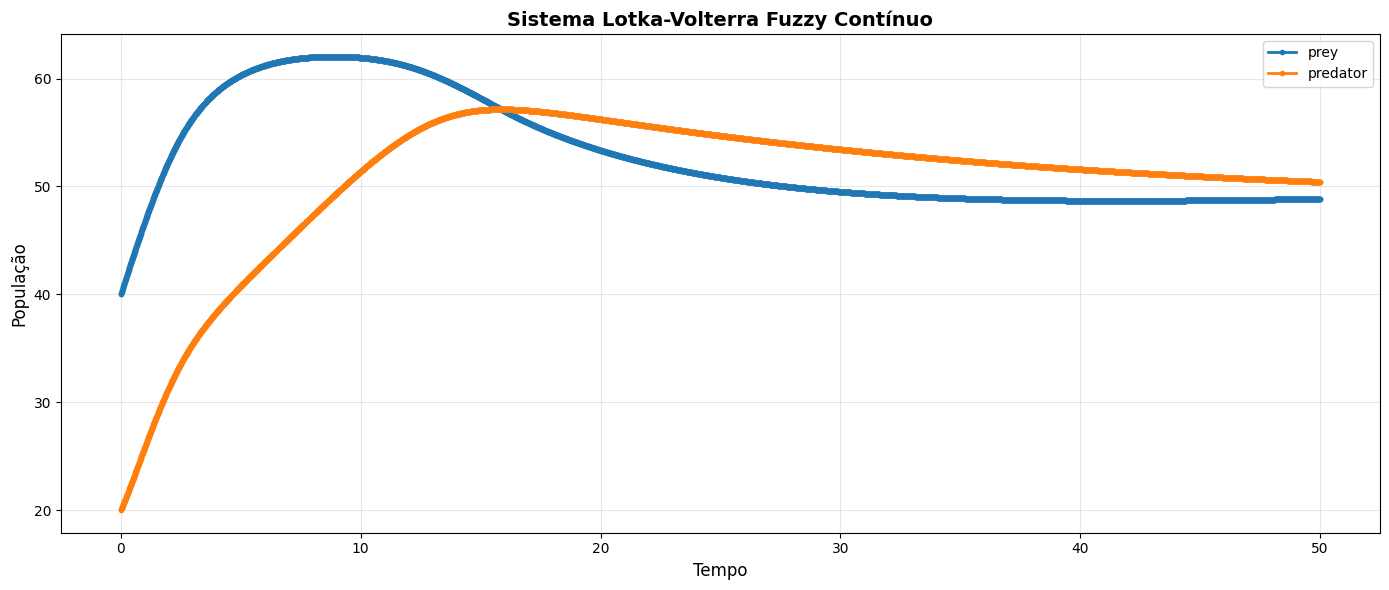

In [8]:
# Plot da dinâmica temporal
fig, ax = pfuzzy.plot_trajectory(
    variables=['prey', 'predator'],
    figsize=(14, 6),
    title='Sistema Lotka-Volterra Fuzzy Contínuo',
    xlabel='Tempo',
    ylabel='População'
)

plt.show()

### 🔄 Espaço de Fase

O espaço de fase mostra a **órbita fechada** típica do sistema predador-presa.

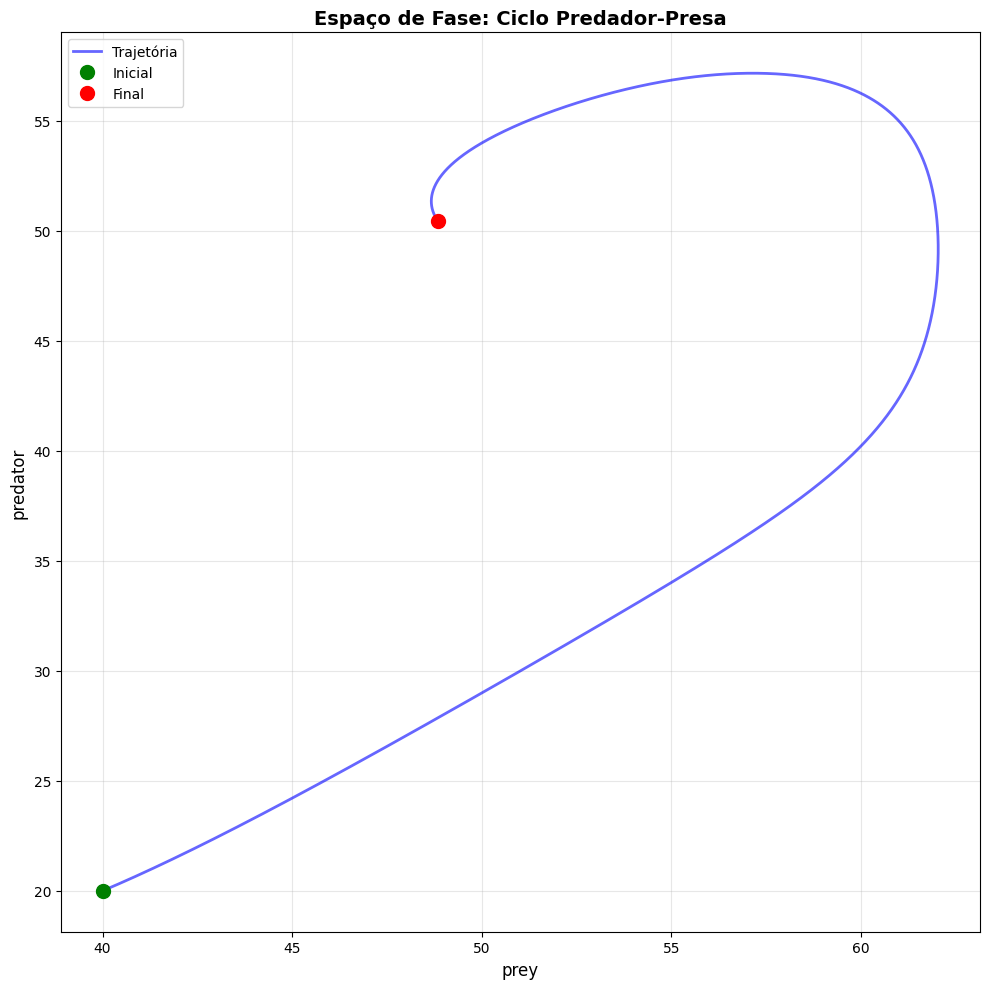

In [9]:
# Plot do espaço de fase
fig, ax = pfuzzy.plot_phase_space(
    'prey', 'predator',
    figsize=(10, 10),
    title='Espaço de Fase: Ciclo Predador-Presa'
)

plt.show()

---

## 5️⃣ Campo Vetorial + Trajetória

Vamos visualizar o **campo de direções** (quiver plot) junto com a trajetória.

In [ ]:
fis.

{'total': 9,
 'by_operator': {'AND': 9},
 'avg_antecedents': 2.0,
 'avg_consequents': 2.0,
 'avg_weight': 1.0,
 'min_weight': 1.0,
 'max_weight': 1.0}

In [19]:
result

{'d_prey': np.float64(15.706199444824884),
 'd_predator': np.float64(-6.730630803792834)}

⚙️  Calculando campo vetorial...


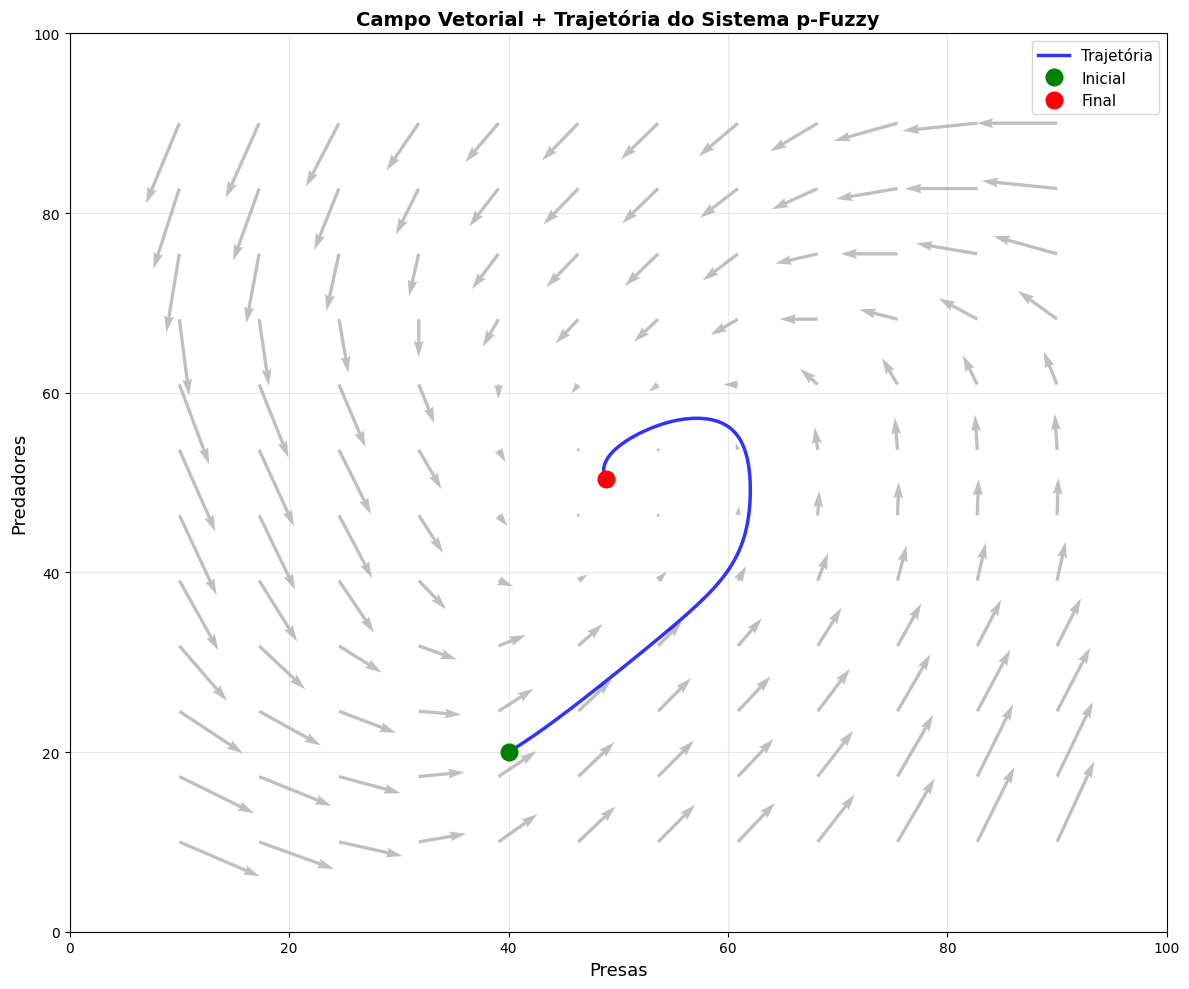

✅ Campo vetorial mostra a direção do fluxo em cada ponto!


In [20]:
# Criar grade para campo vetorial
prey_grid = np.linspace(10, 90, 12)
pred_grid = np.linspace(10, 90, 12)
P, D = np.meshgrid(prey_grid, pred_grid)

# Calcular vetores de campo (dx/dt, dy/dt)
dP = np.zeros_like(P)
dD = np.zeros_like(D)

print("⚙️  Calculando campo vetorial...")

for i in range(len(prey_grid)):
    for j in range(len(pred_grid)):
        state = {'prey': P[j, i], 'predator': D[j, i]}
        result = fis.evaluate(state)
        dP[j, i] = result['d_prey']
        dD[j, i] = result['d_predator']

# Plotar
fig, ax = plt.subplots(figsize=(12, 10))

# Campo vetorial
ax.quiver(P, D, dP, dD, alpha=0.5, color='gray', width=0.003)

# Trajetória
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2.5, 
        label='Trajetória', alpha=0.8)
ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=12, 
        label='Inicial', zorder=5)
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=12, 
        label='Final', zorder=5)

ax.set_xlabel('Presas', fontsize=13)
ax.set_ylabel('Predadores', fontsize=13)
ax.set_title('Campo Vetorial + Trajetória do Sistema p-Fuzzy', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("✅ Campo vetorial mostra a direção do fluxo em cada ponto!")

---

## 6️⃣ Múltiplas Condições Iniciais

Teste diferentes condições iniciais para observar o **espaço de fase global**.

🔄 Simulando múltiplas condições iniciais...

1. Presas=30, Predadores=15
2. Presas=50, Predadores=25
3. Presas=70, Predadores=35
4. Presas=40, Predadores=40


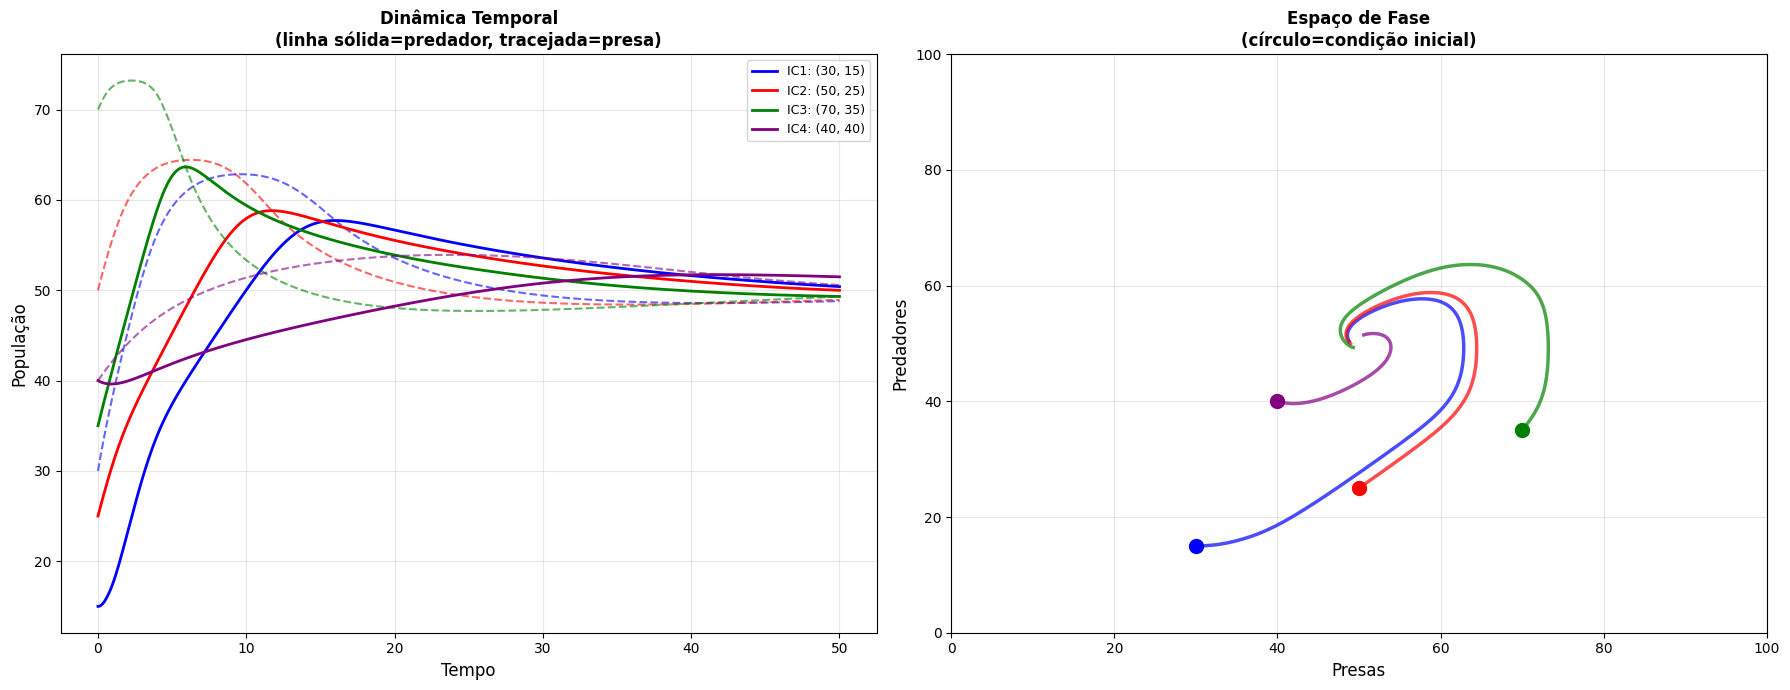


✅ Observação: Diferentes condições iniciais produzem órbitas diferentes!
   → Sistema NÃO possui órbita fechada única (diferente do Lotka-Volterra clássico)


In [11]:
# Diferentes condições iniciais
initial_conditions = [
    {'prey': 30, 'predator': 15},
    {'prey': 50, 'predator': 25},
    {'prey': 70, 'predator': 35},
    {'prey': 40, 'predator': 40}
]

colors = ['blue', 'red', 'green', 'purple']

# Criar figura com 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

print("🔄 Simulando múltiplas condições iniciais...\n")

for i, x0 in enumerate(initial_conditions):
    print(f"{i+1}. Presas={x0['prey']}, Predadores={x0['predator']}")
    
    # Simular
    traj = pfuzzy.simulate(x0=x0, t_span=(0, 50), dt=0.01)
    time = pfuzzy.time
    
    # Plot temporal
    ax1.plot(time, traj[:, 0], '--', color=colors[i], alpha=0.6, linewidth=1.5)
    ax1.plot(time, traj[:, 1], '-', color=colors[i], linewidth=2, 
             label=f"IC{i+1}: ({x0['prey']}, {x0['predator']})")
    
    # Plot espaço de fase
    ax2.plot(traj[:, 0], traj[:, 1], color=colors[i], linewidth=2.5, alpha=0.7)
    ax2.plot(traj[0, 0], traj[0, 1], 'o', color=colors[i], markersize=10)

# Configurar plot temporal
ax1.set_xlabel('Tempo', fontsize=12)
ax1.set_ylabel('População', fontsize=12)
ax1.set_title('Dinâmica Temporal\n(linha sólida=predador, tracejada=presa)', 
              fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# Configurar plot espaço de fase
ax2.set_xlabel('Presas', fontsize=12)
ax2.set_ylabel('Predadores', fontsize=12)
ax2.set_title('Espaço de Fase\n(círculo=condição inicial)', 
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("\n✅ Observação: Diferentes condições iniciais produzem órbitas diferentes!")
print("   → Sistema NÃO possui órbita fechada única (diferente do Lotka-Volterra clássico)")

---

## 7️⃣ Comparação: Euler vs RK4

Vamos comparar os métodos de integração numérica.

⚙️  Simulando com Euler...
⚙️  Simulando com RK4...


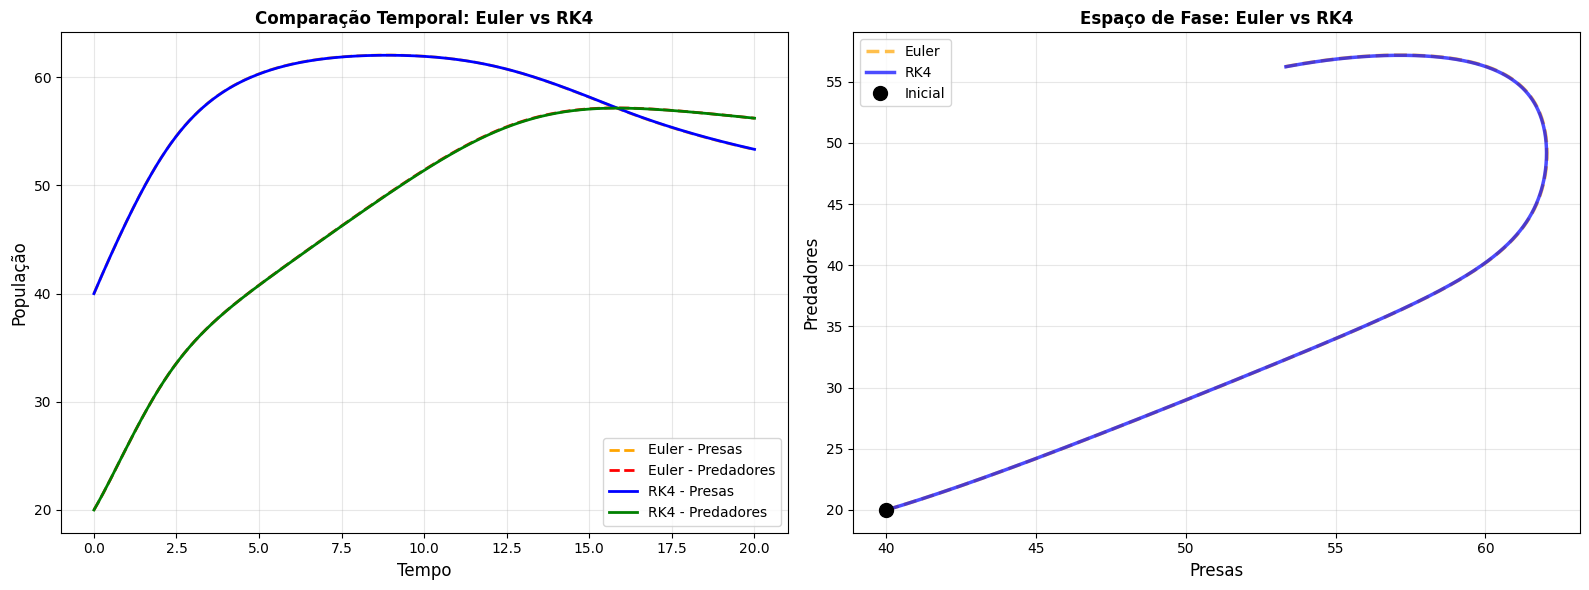


📊 Análise:
   • RK4 é mais preciso (4 avaliações/passo)
   • Euler é mais rápido mas pode acumular erros
   • Para dt pequeno (0.01), ambos convergem


In [13]:
# Criar sistema com Euler
pfuzzy_euler = fs.dynamics.PFuzzyContinuous(
    fis=fis,
    mode='absolute',
    state_vars=['prey', 'predator'],
    method='euler'  # Método de Euler (menos preciso)
)

# Mesma condição inicial
x0_test = {'prey': 40, 'predator': 20}

# Simular ambos
print("⚙️  Simulando com Euler...")
traj_euler = pfuzzy_euler.simulate(x0=x0_test, t_span=(0, 20), dt=0.01)

print("⚙️  Simulando com RK4...")
traj_rk4 = pfuzzy.simulate(x0=x0_test, t_span=(0, 20), dt=0.01)

# Plotar comparação
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Temporal
time = pfuzzy.time
ax1.plot(time, traj_euler[:, 0], '--', color='orange', label='Euler - Presas', linewidth=2)
ax1.plot(time, traj_euler[:, 1], '--', color='red', label='Euler - Predadores', linewidth=2)
ax1.plot(time, traj_rk4[:, 0], '-', color='blue', label='RK4 - Presas', linewidth=2)
ax1.plot(time, traj_rk4[:, 1], '-', color='green', label='RK4 - Predadores', linewidth=2)
ax1.set_xlabel('Tempo', fontsize=12)
ax1.set_ylabel('População', fontsize=12)
ax1.set_title('Comparação Temporal: Euler vs RK4', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Espaço de fase
ax2.plot(traj_euler[:, 0], traj_euler[:, 1], '--', color='orange', 
         label='Euler', linewidth=2.5, alpha=0.7)
ax2.plot(traj_rk4[:, 0], traj_rk4[:, 1], '-', color='blue', 
         label='RK4', linewidth=2.5, alpha=0.7)
ax2.plot(x0_test['prey'], x0_test['predator'], 'ko', markersize=10, label='Inicial')
ax2.set_xlabel('Presas', fontsize=12)
ax2.set_ylabel('Predadores', fontsize=12)
ax2.set_title('Espaço de Fase: Euler vs RK4', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Análise:")
print(f"   • RK4 é mais preciso (4 avaliações/passo)")
print(f"   • Euler é mais rápido mas pode acumular erros")
print(f"   • Para dt pequeno (0.01), ambos convergem")

---

## 8️⃣ Exportar Resultados

In [ ]:
# Exportar para CSV
pfuzzy.to_csv('/tmp/predator_prey_continuous.csv')

print("✅ Dados exportados para: /tmp/predator_prey_continuous.csv")
print("\n📄 Primeiras 5 linhas:")

import pandas as pd
df = pd.read_csv('/tmp/predator_prey_continuous.csv')
print(df.head(10))

---

## 🎯 Conclusões

### ✅ O que aprendemos:

1. **Sistema p-Fuzzy Contínuo:**
   - Evolução por EDOs: $\frac{dx}{dt} = f(x)$
   - Integração numérica: Euler (simples) vs RK4 (preciso)
   - A taxa de mudança é determinada por regras fuzzy

2. **Dinâmica Lotka-Volterra Fuzzy:**
   - **Ciclos oscilatórios** entre presas e predadores
   - Comportamento similar ao modelo clássico
   - Mas com **interpretabilidade** das regras fuzzy

3. **Campo Vetorial:**
   - Mostra a **direção do fluxo** em cada ponto do espaço de fase
   - Útil para entender a dinâmica global do sistema

4. **Vantagens da Abordagem Fuzzy:**
   - ✅ **Não requer parâmetros precisos** (α, β, γ, δ)
   - ✅ **Incorpora conhecimento especialista** via regras
   - ✅ **Interpretável:** "SE presas altas E predadores baixos ENTÃO..."
   - ✅ **Flexível:** Fácil ajustar comportamentos

---

## 🔬 Diferenças: Discreto vs Contínuo

| Aspecto | Discreto | Contínuo |
|---------|----------|----------|
| **Tempo** | Passos discretos | Contínuo |
| **Evolução** | $x_{n+1} = x_n + \Delta x$ | $\frac{dx}{dt} = f(x)$ |
| **Integração** | Não necessária | Euler ou RK4 |
| **Precisão** | Depende do passo | Depende de dt e método |
| **Aplicação** | Eventos discretos | Fenômenos contínuos |

---

## 🧪 Experimentos Sugeridos:

1. **Altere as regras fuzzy:**
   - Adicione competição intraespecífica
   - Teste diferentes estratégias de predação

2. **Explore o espaço de parâmetros:**
   - Mude as funções de pertinência
   - Teste diferentes universos de discurso

3. **Compare com modelo clássico:**
   - Implemente Lotka-Volterra tradicional
   - Compare os resultados

4. **Analise estabilidade:**
   - Procure pontos de equilíbrio
   - Estude a estabilidade das órbitas

---

## 📚 Referências:

- Barros, L. C., Bassanezi, R. C., & Lodwick, W. A. (2017). *A First Course in Fuzzy Logic, Fuzzy Dynamical Systems, and Biomathematics*
- Documentação: https://github.com/1moi6/pyfuzzy-toolbox

---

**🤖 Notebook criado com pyfuzzy-toolbox**